In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
data = pd.read_csv('august_2h_500 (2).csv', index_col='ID')
data.head()

,lvl1_наука_и_техника,lvl1_политика,lvl1_силовые_структуры,lvl1_экономика_и_финансы,lvl1_медиа,lvl1_спорт,lvl1_происшествия,lvl1_бизнес,lvl1_общество_и_путешествия,lvl1_культура
ID,,,,,,,,,,
0,0.069632,0.187841,0.019394,0.115075,0.056799,0.037123,0.00000,0.024163,0.406515,0.083459
1,0.059677,0.177835,0.010065,0.141585,0.031488,0.044724,0.00000,0.006891,0.390816,0.136919
2,0.048920,0.198913,0.016058,0.173857,0.037971,0.055095,0.00000,0.045125,0.356072,0.067989
3,0.070374,0.138846,0.012210,0.186296,0.020574,0.045127,0.00026,0.013610,0.401478,0.111224
4,0.028118,0.136942,0.012192,0.132530,0.022412,0.045134,0.00000,0.009360,0.506849,0.106463


In [36]:
word_data = pd.read_csv('august_2h_100_words_norm.csv')
word_data.head()

,ID,android,associated,august,az,bmw,by,cnn,co,createelement,...,яркий,яркий_пример,яркий_событие,ярмарка,ярослав,ярославль,ярославский,ярославский_область,ясно,ясный
0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.00004,0.00000,0.0,0.0,0.000000,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.000043,0.0,0.0,0.000000,...,0.000084,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.000037,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.000041,0.0,0.0,0.000060,...,0.000000,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.000000,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000056,...,0.000000,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.000033,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000139,0.00000,0.00006,0.0,0.0,0.000038,0.0


In [37]:
#read data about fucking titles into titles[][]
n_hours = 3600
n_titles = 20
titles = data.values
n_hours, n_titles = titles.shape
n_hours, n_titles

(371, 10)

In [38]:
words = word_data.values
n_hours, n_words = words.shape
n_hours, n_words

(371, 9297)

In [39]:
n_pred = 24#количество предыдущих значений для использования
mean = titles.mean(axis=0)
std = np.sqrt((titles ** 2).sum(axis=0))
mean.shape,std.shape

((10,), (10,))

In [40]:
centered_std = np.sqrt(((titles - mean) ** 2).sum(axis=0))
centered_std.shape

(10,)

In [42]:
word_mean = words.mean(axis=0)
word_std = np.sqrt((words ** 2).sum(axis=0))
word_mean.shape, word_std.shape

((9297,), (9297,))

In [9]:
target = titles[n_pred:, :]
feature = np.zeros((target.shape[0], n_pred * n_titles * 2 + word_mean.shape))
for i in np.arange(n_pred, n_hours):
    feature[i-n_pred, :] = np.hstack((titles[i-n_pred:i, :] / std, 
                                      (titles[i-n_pred:i, :] - mean) / centered_std)).ravel()

In [10]:
titles.shape, target.shape, feature.shape

((743, 10), (695, 10), (695, 960))

In [11]:
train_target, train_feature, test_target, test_feature = target[:-7*12, :], feature[:-7*12, :], target[-7*12:, :], feature[-7*12:, :]
train_target.shape, train_feature.shape, test_target.shape, test_feature.shape

((527, 10), (527, 960), (168, 10), (168, 960))

In [12]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm_notebook

In [13]:
params_grid = [{'alpha':np.arange(0.00005, 0.0002, 0.00005), 'l1_ratio':np.arange(0.1, 1, 0.25), 
                'fit_intercept':[False], 'normalize':[False], 'max_iter':[10000], 'tol':[0.0001]}]

scores = ['MSE', 'MAE']
bMSE = 100
bMAE = 100

for param in tqdm_notebook(ParameterGrid(params_grid)):
    print(param)
    #model = ElasticNet(alpha=0.00005, l1_ratio=0.5, fit_intercept=True, normalize=True, max_iter=10000)
    model=ElasticNet(**param)
    model.fit(train_feature, train_target)
    cur_feature = np.hstack((train_feature[-1, 2 * n_titles:], train_target[-1, :] / std, 
                             (train_target[-1, :] - mean) / centered_std))
    prediction = np.zeros_like(test_target)
    for i in range(test_target.shape[0]):
        predicted = model.predict(cur_feature.reshape((1, -1)))
        prediction[i, :] = predicted
        cur_feature = np.hstack((cur_feature[2 * n_titles:], predicted.ravel() / std, 
                                 (predicted.ravel() - mean) / centered_std))
    MAE = mean_absolute_error(test_target, prediction)
    MSE = mean_squared_error(test_target, prediction)
    if MAE < bMAE:
        bMAE = MAE
        best_MAE_model = param
    if MSE < bMSE:
        bMSE = MSE
        best_MSE_model = param
    print('     MAE', MAE)
    print('     MSE', MSE)

{'alpha': 5e-05, 'fit_intercept': False, 'l1_ratio': 0.1, 'max_iter': 10000, 'normalize': False, 'tol': 0.0001}


/home/philipp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


     MAE 0.04607234944550574
     MSE 0.004514164449026579
{'alpha': 5e-05, 'fit_intercept': False, 'l1_ratio': 0.35, 'max_iter': 10000, 'normalize': False, 'tol': 0.0001}
     MAE 0.04405592296920628
     MSE 0.004158827777213759
{'alpha': 5e-05, 'fit_intercept': False, 'l1_ratio': 0.6, 'max_iter': 10000, 'normalize': False, 'tol': 0.0001}
     MAE 0.04327296783358515
     MSE 0.004039803082131245
{'alpha': 5e-05, 'fit_intercept': False, 'l1_ratio': 0.8499999999999999, 'max_iter': 10000, 'normalize': False, 'tol': 0.0001}
     MAE 0.04283691774905908
     MSE 0.0039863816660217185
{'alpha': 0.0001, 'fit_intercept': False, 'l1_ratio': 0.1, 'max_iter': 10000, 'normalize': False, 'tol': 0.0001}
     MAE 0.044400554985949706
     MSE 0.004226028323892654
{'alpha': 0.0001, 'fit_intercept': False, 'l1_ratio': 0.35, 'max_iter': 10000, 'normalize': False, 'tol': 0.0001}
     MAE 0.04283294270331835
     MSE 0.0039688823983391585
{'alpha': 0.0001, 'fit_intercept': False, 'l1_ratio': 0.6, 'max_

In [14]:
best_MAE_model, best_MSE_model

({'alpha': 0.00015000000000000001,
  'fit_intercept': False,
  'l1_ratio': 0.8499999999999999,
  'max_iter': 10000,
  'normalize': False,
  'tol': 0.0001},
 {'alpha': 0.00015000000000000001,
  'fit_intercept': False,
  'l1_ratio': 0.6,
  'max_iter': 10000,
  'normalize': False,
  'tol': 0.0001})

In [25]:
model = ElasticNet(**best_MSE_model)
model.alpha = 0.0001
model.fit(train_feature, train_target)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=False, l1_ratio=0.6,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
cur_feature = np.hstack((train_feature[-1, 2 * n_titles:], train_target[-1, :] / std, 
                             (train_target[-1, :] - mean) / centered_std))
prediction = np.zeros_like(test_target)
for i in range(test_target.shape[0]):
    predicted = model.predict(cur_feature.reshape((1, -1)))
    prediction[i, :] = predicted
    cur_feature = np.hstack((cur_feature[2 * n_titles:], predicted.ravel() / std, 
                             (predicted.ravel() - mean) / centered_std))

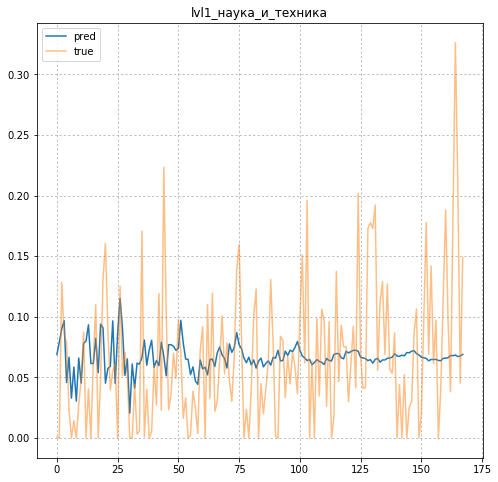

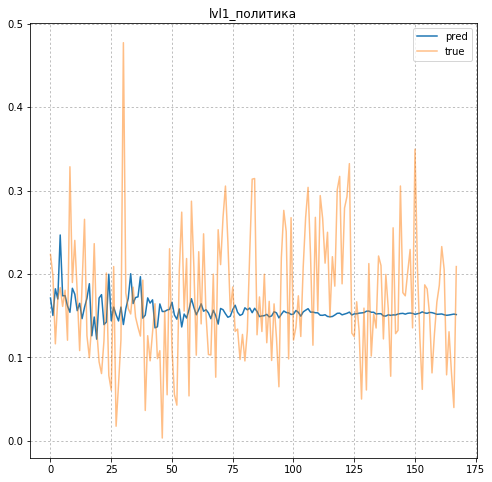

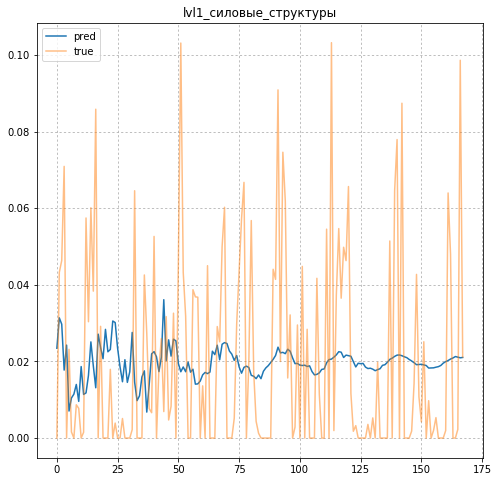

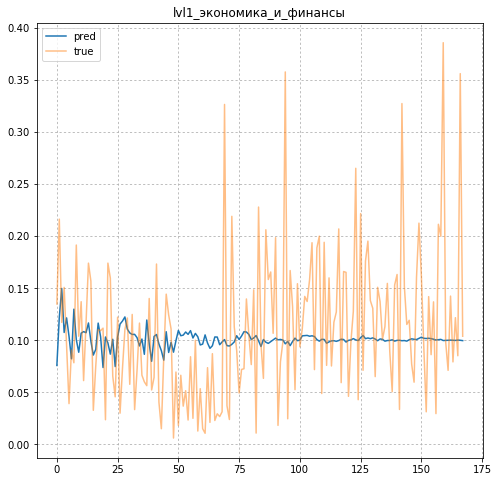

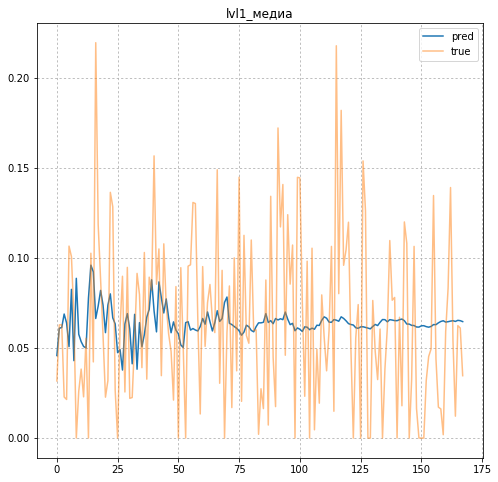

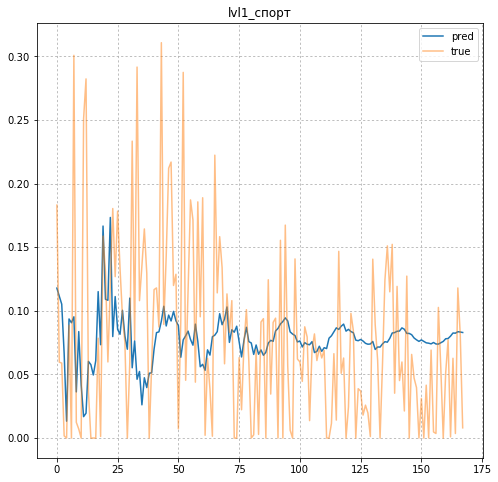

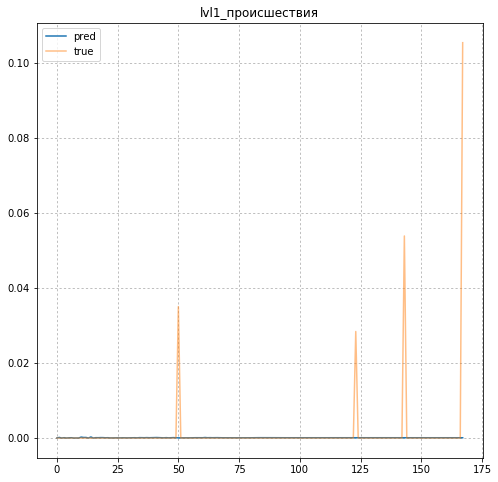

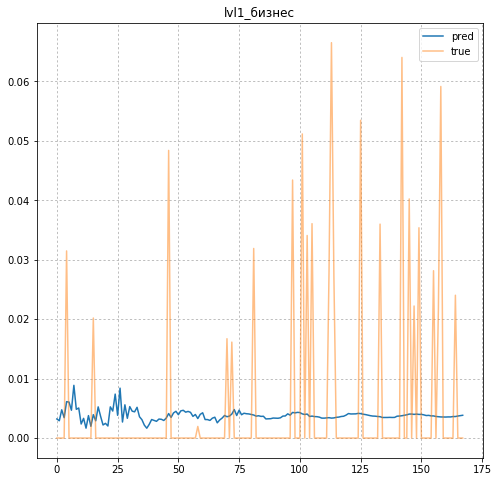

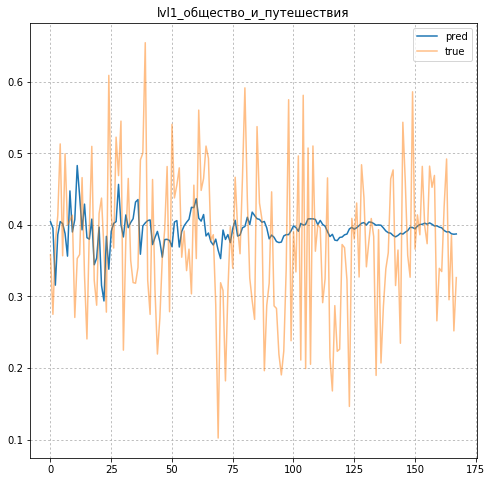

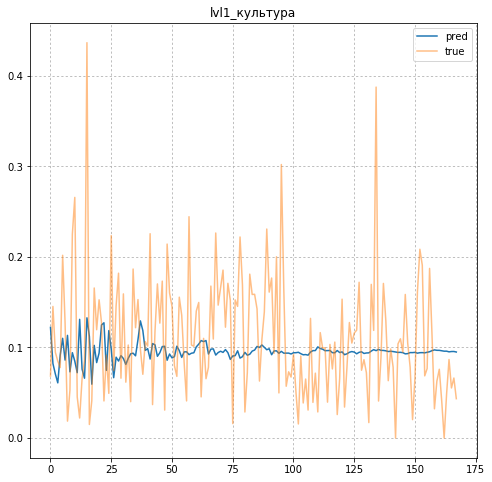

In [27]:
for i in range(n_titles):
    plt.figure(figsize=(8, 8))
    size = prediction.shape[0]
    plt.plot(np.arange(size), prediction[:size, i], label='pred')
    plt.plot(np.arange(size), test_target[:size, i], label='true', alpha=0.5)
    plt.legend()
    plt.title(data.columns[i])
    plt.grid(ls=':')
    plt.show()

In [32]:
prediction.sum(axis=1).mean()

0.9776855104119607

In [28]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_target, prediction, 
                   multioutput='raw_values').sum(), mean_absolute_error(test_target,prediction, 
                                                                        multioutput='raw_values').sum()

(0.038931091122729924, 0.4224991575229783)

In [79]:
model.coef_.shape

(10, 480)

In [89]:
predicted.sum(axis=1).mean()

1.0